In [98]:
import csv
import pandas as pd
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [99]:
#load the three years data
df_1 = pd.read_csv("SPARCS2014.csv", index_col = None, header = 0, low_memory = False)
df_2 = pd.read_csv("SPARCS2015.csv", index_col = None, header = 0, low_memory = False)
df_3 = pd.read_csv("SPARCS2016.csv", index_col = None, header = 0, low_memory = False)

In [379]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2343429 entries, 0 to 2343428
Data columns (total 38 columns):
Health Service Area                      object
Hospital County                          object
Operating Certificate Number             float64
Facility Id                              float64
Facility Name                            object
Age Group                                object
Zip Code - 3 digits                      object
Gender                                   object
Race                                     object
Ethnicity                                object
Length of Stay                           object
Type of Admission                        object
Patient Disposition                      object
Discharge Year                           int64
CCS Diagnosis Code                       int64
CCS Diagnosis Description                object
CCS Procedure Code                       int64
CCS Procedure Description                object
APR DRG Code            

In [368]:
# select the patient who has Asthma Diagnosis
df_16 = df_3[df_3['CCS Diagnosis Description'] == 'Asthma']
df_15 = df_2[df_2['CCS Diagnosis Description'] == 'Asthma']
df_14 = df_1[df_1['CCS Diagnosis Description'] == 'Asthma']

In [ ]:
df_16.info

In [369]:
#merge three years data
df = pd.concat([df_14, df_15,df_16],sort=False)

In [370]:
#since there are 37 columns most of them are not useful for the project obejective, we will drop them
columns = ['Health Service Area','Hospital County','Operating Certificate Number', 'Facility ID',
        'Facility Name','CCS Diagnosis Code','CCS Procedure Code','CCS Procedure Description',
        'APR DRG Code','APR DRG Description','Payment Typology 2','Payment Typology 3',
        'Attending Provider License Number','Operating Provider License Number','Other Provider License Number',
        'Facility Id','Ratio of Total Costs to Total Charges','Zip Code - 3 digits','APR Severity of Illness Description',
        'APR MDC Code','APR MDC Description','CCS Diagnosis Description','Total Costs','Patient Disposition']
df.drop(columns, inplace=True, axis=1)

In [371]:
# check if there are missing values
df.isnull().sum()

Age Group                           0
Gender                              0
Race                                0
Ethnicity                           0
Length of Stay                      0
Type of Admission                   0
Discharge Year                      0
APR Severity of Illness Code        0
APR Risk of Mortality               0
APR Medical Surgical Description    0
Payment Typology 1                  0
Birth Weight                        0
Abortion Edit Indicator             0
Emergency Department Indicator      0
Total Charges                       0
dtype: int64

In [372]:
# check the colum
df['Birth Weight'].value_counts()

0       85924
3200        1
Name: Birth Weight, dtype: int64

In [373]:
#drop this columns
df.drop('Birth Weight',axis = 1, inplace=True)

In [374]:
# select main payment method
df = df[df['Payment Typology 1'] != 'Unknown']
df = df[df['Payment Typology 1'] != 'Self-Pay']
df = df[df['Payment Typology 1'] != 'Managed Care, Unspecified']
df = df[df['Payment Typology 1'] != 'Miscellaneous/Other']
df = df[df['Payment Typology 1'] != 'Federal/State/Local/VA']
df = df[df['Payment Typology 1'] != 'Department of Corrections']

In [375]:
# add a new column length to deal with 120+ to 120
new = df['Length of Stay'].str.split(" ", n = 1, expand = True)
df['length']=new[0]
df['length']=pd.to_numeric(df.length)
df = df[df['length'] <= 20]

In [376]:

df['APR Medical Surgical Description'].value_counts()

Medical     81593
Surgical      282
Name: APR Medical Surgical Description, dtype: int64

In [319]:
df_anova = df[['length','Payment Typology 1']]
grps = pd.unique(df_anova['Payment Typology 1'])
d_data = {grp:df_anova['length'][df_anova['Payment Typology 1'] == grp] for grp in grps}
grps

array(['Medicare', 'Blue Cross/Blue Shield', 'Medicaid',
       'Private Health Insurance'], dtype=object)

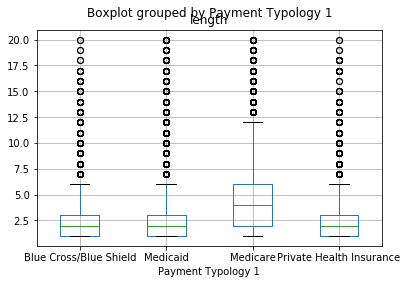

In [320]:
df_anova.boxplot('length',by = 'Payment Typology 1')

In [321]:
from scipy import stats

In [366]:
F, p = stats.f_oneway(d_data['Blue Cross/Blue Shield'], d_data['Medicare'], d_data['Medicaid'],d_data['Private Health Insurance'])
print("p-value for significance is: ", p)
if p<0.05:
   print("reject null hypothesis")
else: 
  print("accept null hypothesis")

p-value for significance is:  0.0 2540.3909634969077
reject null hypothesis


In [ ]:
#post-hoc test : Turkey-kramer 

In [323]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [325]:
print(pairwise_tukeyhsd(df['length'],df['Payment Typology 1']))

                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                  
        group1                  group2          meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------------
Blue Cross/Blue Shield                 Medicaid  -0.0743 0.0627 -0.1512  0.0026  False
Blue Cross/Blue Shield                 Medicare   1.6744  0.001  1.5911  1.7578   True
Blue Cross/Blue Shield Private Health Insurance  -0.0158    0.9 -0.1109  0.0793  False
              Medicaid                 Medicare   1.7488  0.001  1.6953  1.8022   True
              Medicaid Private Health Insurance   0.0585  0.142 -0.0119  0.1289  False
              Medicare Private Health Insurance  -1.6902  0.001 -1.7676 -1.6129   True
--------------------------------------------------------------------------------------


Blue Cross/Blue Shield  and Medicaid have no statistical difference.

In [327]:
df.drop('Length of Stay',inplace=True,axis=1)

In [328]:
df['Age Group'].value_counts()

0 to 17        30765
50 to 69       21550
30 to 49       12570
70 or Older    11934
18 to 29        5056
Name: Age Group, dtype: int64

In [329]:
#deal with age group to demean it

for i in df['Age Group']:
    if i == '0 to 17':
        df['new_age'] = 17/2
    if i == '50 to 69':
        df['new_age'] = (69-50)/2
    if i == '30 to 49':
        df['new_age'] = (49-30)/2
    if i == '70 or Older':
        df['new_age'] = 70
    if i == '18 to 29':
        df['new_age'] = (29-18)/2

In [330]:
df.loc[df['Age Group'] == '0 to 17','new_age'] = 17/2
df.loc[df['Age Group'] == '50 to 69','new_age'] = (69-50)/2
df.loc[df['Age Group'] == '30 to 49','new_age'] = (49-30)/2
df.loc[df['Age Group'] == '70 or Older','new_age'] = 70
df.loc[df['Age Group'] == '18 to 29','new_age'] = (29-18)/2

In [331]:
df.drop('Age Group',inplace=True,axis=1)

In [332]:
df['new_age'].value_counts()

9.5     34120
8.5     30765
70.0    11934
5.5      5056
Name: new_age, dtype: int64

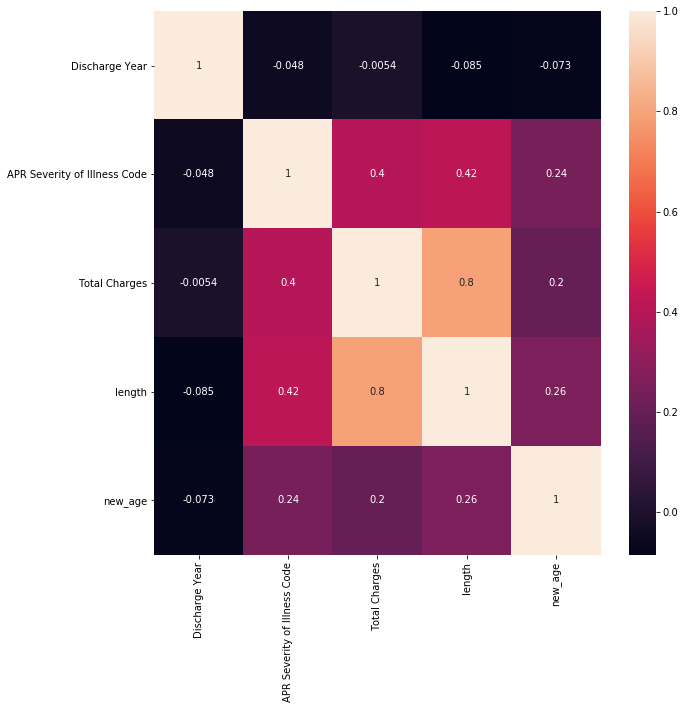

In [333]:
plt.figure(figsize=[10,10])
sns.heatmap(df.corr(),annot=True)

In [ ]:
#deal with binary varible 
#Gender,Abortion Edit Indicator,'APR Medical Surgical Description'Emergency Department Indicator

In [56]:
# deal with category varible 
#Race,Ethnicity,Type of Admission,Patient Disposition,Discharge Year,APR Severity of Illness Code,APR Risk of Mortality,Payment Typology 1

Diseases and Disorders of the Respiratory System    81875
Name: APR MDC Description, dtype: int64

In [334]:
df['Emergency Department Indicator'].value_counts()

Y    73005
N     8870
Name: Emergency Department Indicator, dtype: int64

In [335]:
#hot-encoding for category varible 
df= pd.get_dummies(df,columns = ['Race','Ethnicity','Type of Admission','Discharge Year','APR Severity of Illness Code','APR Risk of Mortality','Payment Typology 1'])

In [336]:
cat_columns = ['Race_Black/African American','Ethnicity_Multi-ethnic','Type of Admission_Elective','Discharge Year_2014','APR Severity of Illness Code_1',
'APR Risk of Mortality_Extreme','Payment Typology 1_Blue Cross/Blue Shield']
df.drop(cat_columns, inplace=True, axis=1)

In [337]:
#deal with binary varible 
binary = ['Gender','Abortion Edit Indicator','APR Medical Surgical Description','Emergency Department Indicator']
i = 0
for i in binary:
    df[i] = df[i].astype('category')
    df[i] = df[i].cat.codes

In [367]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 81875 entries, 34 to 2343370
Data columns (total 27 columns):
Gender                                         81875 non-null int8
APR Medical Surgical Description               81875 non-null int8
Abortion Edit Indicator                        81875 non-null int8
Emergency Department Indicator                 81875 non-null int8
Total Charges                                  81875 non-null float64
length                                         81875 non-null int64
new_age                                        81875 non-null float64
Race_Multi-racial                              81875 non-null uint8
Race_Other Race                                81875 non-null uint8
Race_White                                     81875 non-null uint8
Ethnicity_Not Span/Hispanic                    81875 non-null uint8
Ethnicity_Spanish/Hispanic                     81875 non-null uint8
Ethnicity_Unknown                              81875 non-null uint8
Type

0    81593
1      282
Name: APR Medical Surgical Description, dtype: int64

In [349]:
columns = ['Payment Typology 1_Medicaid','Payment Typology 1_Medicare','Payment Typology 1_Private Health Insurance']
df_fe = df.drop(columns,axis=1)

In [350]:
def fit_linear_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = linear_model.LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared

In [351]:
from tqdm import tnrange, tqdm_notebook
import itertools
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from statsmodels.formula.api import ols

In [353]:
df_fe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81875 entries, 34 to 2343370
Data columns (total 26 columns):
Gender                              81875 non-null int8
APR Medical Surgical Description    81875 non-null int8
Abortion Edit Indicator             81875 non-null int8
Emergency Department Indicator      81875 non-null int8
Total Charges                       81875 non-null float64
length                              81875 non-null int64
new_age                             81875 non-null float64
Race_Multi-racial                   81875 non-null uint8
Race_Other Race                     81875 non-null uint8
Race_White                          81875 non-null uint8
Ethnicity_Not Span/Hispanic         81875 non-null uint8
Ethnicity_Spanish/Hispanic          81875 non-null uint8
Ethnicity_Unknown                   81875 non-null uint8
Type of Admission_Emergency         81875 non-null uint8
Type of Admission_Newborn           81875 non-null uint8
Type of Admission_Not Available  

In [356]:
#Initialization variables
Y = df_fe.length
X = df_fe.drop(columns = 'length',axis = 1)
k = 25

remaining_features = list(X.columns.values)
features = []
RSS_list, R_squared_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
features_list = dict()

for i in range(1,k+1):
    best_RSS = np.inf
    
    for combo in itertools.combinations(remaining_features,1):

            RSS = fit_linear_reg(X[list(combo) + features],Y)   #Store temp result 

            if RSS[0] < best_RSS:
                best_RSS = RSS[0]
                best_R_squared = RSS[1] 
                best_feature = combo[0]

    #Updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)
    
    #Saving values for plotting
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list[i] = features.copy()

In [360]:
print('Forward stepwise subset selection')
print('Number of features |', 'Features |', 'RSS')
display([(i,features_list[i], round(RSS_list[i])) for i in range(1,25)])

Forward stepwise subset selection
Number of features | Features | RSS


[(1, ['Total Charges'], 198530.0),
 (2, ['Total Charges', 'APR Risk of Mortality_Minor'], 191570.0),
 (3,
  ['Total Charges', 'APR Risk of Mortality_Minor', 'Discharge Year_2016'],
  189122.0),
 (4,
  ['Total Charges',
   'APR Risk of Mortality_Minor',
   'Discharge Year_2016',
   'new_age'],
  187302.0),
 (5,
  ['Total Charges',
   'APR Risk of Mortality_Minor',
   'Discharge Year_2016',
   'new_age',
   'Gender'],
  186013.0),
 (6,
  ['Total Charges',
   'APR Risk of Mortality_Minor',
   'Discharge Year_2016',
   'new_age',
   'Gender',
   'APR Severity of Illness Code_3'],
  184921.0),
 (7,
  ['Total Charges',
   'APR Risk of Mortality_Minor',
   'Discharge Year_2016',
   'new_age',
   'Gender',
   'APR Severity of Illness Code_3',
   'Race_White'],
  184190.0),
 (8,
  ['Total Charges',
   'APR Risk of Mortality_Minor',
   'Discharge Year_2016',
   'new_age',
   'Gender',
   'APR Severity of Illness Code_3',
   'Race_White',
   'Ethnicity_Unknown'],
  183636.0),
 (9,
  ['Total Charg

In [358]:
df1 = pd.concat([pd.DataFrame({'features':features_list}),pd.DataFrame({'RSS':RSS_list, 'R_squared': R_squared_list})], axis=1, join='inner')
df1['numb_features'] = df1.index

In [359]:
#Initializing useful variables
m = len(Y)
p = 34
hat_sigma_squared = (1/(m - p -1)) * min(df1['RSS'])

#Computing
df1['C_p'] = (1/m) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['AIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['BIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] +  np.log(m) * df1['numb_features'] * hat_sigma_squared )
df1['R_squared_adj'] = 1 - ( (1 - df1['R_squared'])*(m-1)/(m-df1['numb_features'] -1))


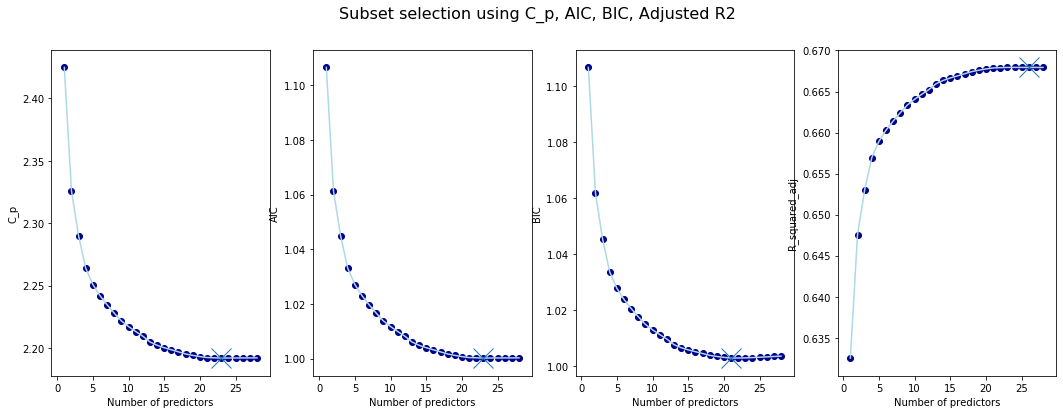

In [347]:
variables = ['C_p', 'AIC','BIC','R_squared_adj']
fig = plt.figure(figsize = (18,6))

for i,v in enumerate(variables):
    ax = fig.add_subplot(1, 4, i+1)
    ax.plot(df1['numb_features'],df1[v], color = 'lightblue')
    ax.scatter(df1['numb_features'],df1[v], color = 'darkblue')
    if v == 'R_squared_adj':
        ax.plot(df1[v].idxmax(),df1[v].max(), marker = 'x', markersize = 20)
    else:
        ax.plot(df1[v].idxmin(),df1[v].min(), marker = 'x', markersize = 20)
    ax.set_xlabel('Number of predictors')
    ax.set_ylabel(v)

fig.suptitle('Subset selection using C_p, AIC, BIC, Adjusted R2', fontsize = 16)
plt.show()

In [362]:
df_fe.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 81875 entries, 34 to 2343370
Data columns (total 26 columns):
Gender                              81875 non-null int8
APR Medical Surgical Description    81875 non-null int8
Abortion Edit Indicator             81875 non-null int8
Emergency Department Indicator      81875 non-null int8
Total Charges                       81875 non-null float64
length                              81875 non-null int64
new_age                             81875 non-null float64
Race_Multi-racial                   81875 non-null uint8
Race_Other Race                     81875 non-null uint8
Race_White                          81875 non-null uint8
Ethnicity_Not Span/Hispanic         81875 non-null uint8
Ethnicity_Spanish/Hispanic          81875 non-null uint8
Ethnicity_Unknown                   81875 non-null uint8
Type of Admission_Emergency         81875 non-null uint8
Type of Admission_Newborn           81875 non-null uint8
Type of Admission_Not Available  

In [364]:

columns = ['Type of Admission_Not Available','APR Risk of Mortality_Major']
df = df.drop(columns,axis=1)

In [95]:
import statsmodels.api as sm

In [365]:
Y = df.length
X = df.drop(columns = 'length',axis = 1)
X = sm.add_constant(X)
model_1 = sm.OLS(Y, X)
result_1 = model_1.fit()
result_1.summary()

C:\Users\Naixin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 length   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     6335.
Date:                Thu, 17 Oct 2019   Prob (F-statistic):               0.00
Time:                        23:16:50   Log-Likelihood:            -1.4828e+05
No. Observations:               81875   AIC:                         2.966e+05
Df Residuals:                   81848   BIC:                         2.969e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                           1.5030      0.101     14.916      0.000       1.306       1.701
Gender                                         -0.2216      0.011    -20.568      0.000      -0.243      -0.200
APR Medical Surgical Description               -0.9679      0.090    -10.725      0.000      -1.145      -0.791
Abortion Edit Indicator                         0.8870      0.857      1.035      0.301      -0.792       2.566
Emergency Department Indicator                  0.1018      0.019      5.485      0.000       0.065       0.138
Total Charges                                8.899e-05   2.75e-07    323.546      0.000    8.84e-05    8.95e-05
new_age                                         0.0029      0.000      8.888      0.000       0.002       0.004
Race_Multi-racial                              -0.4928      0.064     -7.697      0.000      -0.618      -0.367
Race_Other Race                                -0.1246      0.014     -8.664      0.000      -0.153      -0.096
Race_White                                      0.1442      0.014     10.620      0.000       0.118       0.171
Ethnicity_Not Span/Hispanic                     0.3253      0.074      4.373      0.000       0.179       0.471
Ethnicity_Spanish/Hispanic                      0.2452      0.075      3.282      0.001       0.099       0.392
Ethnicity_Unknown                               0.6956      0.077      8.988      0.000       0.544       0.847
Type of Admission_Emergency                    -0.6610      0.059    -11.239      0.000      -0.776      -0.546
Type of Admission_Newborn                      -0.9151      1.048     -0.873      0.383      -2.970       1.140
Type of Admission_Trauma                       -0.2897      0.527     -0.550      0.582      -1.322       0.742
Type of Admission_Urgent                       -0.4343      0.065     -6.644      0.000      -0.562      -0.306
Discharge Year_2015                            -0.1814      0.012    -15.111      0.000      -0.205      -0.158
Discharge Year_2016                            -0.4206      0.013    -31.669      0.000      -0.447      -0.395
APR Severity of Illness Code_2                  0.1754      0.012     14.206      0.000       0.151       0.200
APR Severity of Illness Code_3                  0.4682      0.023     20.233      0.000       0.423       0.514
APR Severity of Illness Code_4                  0.2830      0.045      6.222      0.000       0.194       0.372
APR Risk of Mortality_Minor                    -0.3333      0.028    -11.828      0.000      -0.389      -0.278
APR Risk of Mortality_Moderate                 -0.2286      0.024     -9.338      0.000      -0.277      -0.181
Payment Typology 1_Medicaid                     0.1520     